# Our first nipype workflow

You can think of a nipype workflow (or any neuroimaging pipeline) as a [Directed Acyclic Graph (or DAG)](https://en.wikipedia.org/wiki/Directed_acyclic_graph), or a series of operations that can be performed serially or in parallel, and in which loops are not allowed (that is, the output of a child cannot be the input of a parent). Think of water flowing down a mountain slope (your input data), splitting into smaller rivers (your processes), and ending into a lake (the output data).

In Nipype, each vertex in the graph is either a `Node` object, which wraps an `Interface`, or another `Workflow`. Note that by using other workflows as vertices, nipype can generate modular pipelines, which will be useful when developing more complicated pipelines. In addition, it makes testing the individual parts of your pipeline much easier.

Writing nipype workflows is fairly straightforward after you have enough practice with the syntax. In my experience, the best way to write a workflow is by first drawing it on paper, and then moving to the code. Let's write a very simple pipeline that does the following on the input data

1. perform motion correction
2. estimate TSNR on the motion-corrected data
3. take the motion correction parameters and estimate framewise displacement

Or as a graph:

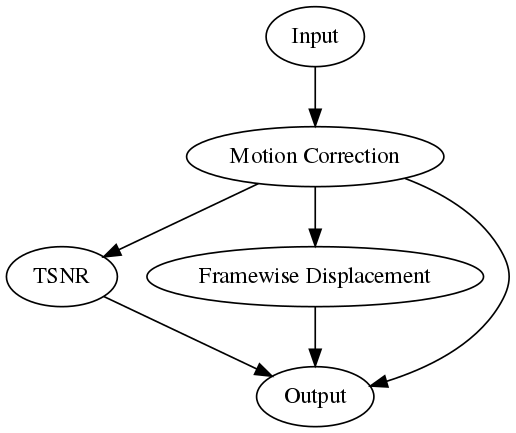

In [63]:
import networkx as nx
from nxpd import draw
G = nx.DiGraph()
G.graph['dpi'] = 120
G.add_nodes_from(['Input', 'Motion Correction', 'TSNR', 'Framewise Displacement', 'Output'])
G.add_edges_from([
    ('Input', 'Motion Correction'),
    ('Motion Correction', 'TSNR'),
    ('Motion Correction', 'Framewise Displacement'),
    ('TSNR', 'Output'),
    ('Motion Correction', 'Output'),
    ('Framewise Displacement', 'Output')
])
draw(G, show='ipynb')

In [64]:
from nipype import Workflow, Node, IdentityInterface
from nipype.interfaces import afni
from nipype.interfaces import fsl
from nipype.algorithms.confounds import FramewiseDisplacement, TSNR

First, we need to setup an input node and an output node. For this special type of node we are going to use an `IdentityInterface`. This interface simply creates identity mappings. They are used to collect input and output files.

In [65]:
inputnode = Node(
    IdentityInterface(
        # fields specify what input/output fields this node will have.
        # In this case, the node `inputnode` will have an input called `in_file` 
        # and an output called `in_file`
        fields=['in_file']),
    name='inputnode'
)

outputnode = Node(
    IdentityInterface(fields=['tsnr_file', 'moco_file', 'fd']),
    name='outputnode'
)

Then we can create the intermediate nodes that will perform actions on the input data. We will use FSL's `MCFLIRT` for motion correction, AFNI's `3dTstat` for computing tSNR, and Nipype's `algorithms.confounds.FramewiseDisplacement` to compute framewise displacement from MCFLIRT's motion parameters. This example also shows you how easy it is to mix and match tools from different neuroimaging toolkits.

In [66]:
flirt = Node(
    fsl.MCFLIRT(output_type='NIFTI_GZ', save_plots=True), 
    name='flirt'
)
fd = Node(
    FramewiseDisplacement(parameter_source='FSL'),
    name='compute_fd'
)

# we are going to use afni to compute tSNR
# the option -cvarinv of 3dTstat computes tSNR after linear detrending
tsnr = Node(
    afni.TStat(outputtype='NIFTI_GZ', args='-cvarinv'),
    name='compute_tsnr'
)

Now we are ready to link all these nodes together. First, we create an instance of a `Workflow` object. The only mandatory argument is its name.

In [41]:
wf = Workflow(name='my_first_workflow')

Then, we are ready to connect the nodes using the method `Workflow.connect`. This method can be used in two ways. In its simplest form, the syntax is

```python
Workflow.connect(in_node, "output_field", out_node, "input_field")
```

that is, we are linking `in_node` to `out_node` by passing `"output_field"` (of `in_node`) to `"input_field"` (of `out_node`).

In [42]:
# first way to connect nodes
# wf.connect(in_node, output_field, out_node, input_field)
#
# input data -> flirt
wf.connect(inputnode, 'in_file', flirt, 'in_file')

Alternatively, if we need to link many fields of the same node to another node, we can use the syntax

```python
Workflow.connect([  # this is a list of tuple
    # each tuple has three elements
    # the first two elements are the input and output nodes
    (in_node, out_node, # <-- which nodes to connect?
       # the last element is a list of tuples indicating the fields to connect
       [("output_field_1", "input_field_1"),  # <-- which fields to connect?
        ("output_field_2", "input_field_2")])
])
```

This is very confusing at first, and you might get lost in brackets (use an IDE for this). However, when you get used to it, it becomes very efficient and you will never use the first syntax.

In [43]:
wf.connect([
    # moco params -> framewise displacement
    (flirt, fd, [('par_file', 'in_file')]),
    # moco file -> tsnr
    (flirt, tsnr, [('out_file', 'in_file')]),
    # moco file -> output node
    (flirt, outputnode, [('out_file', 'moco_file')]),
    # tsnr file -> output node
    (tsnr, outputnode, [('out_file', 'tsnr_file')]),
    # framewise displacement -> output node
    (fd, outputnode, [('out_file', 'fd')])
])

That's it. We created our first workflow! We can visualize it to make sure we have connected everything properly.

210422-16:14:58,768 nipype.workflow INFO:
	 Generated workflow graph: /home/jlg/mvdoc/gbox/experiments/mvdoc-explorations/2021-04-20-nipype-tutorial/myfirstworkflow.png (graph2use=hierarchical, simple_form=True).


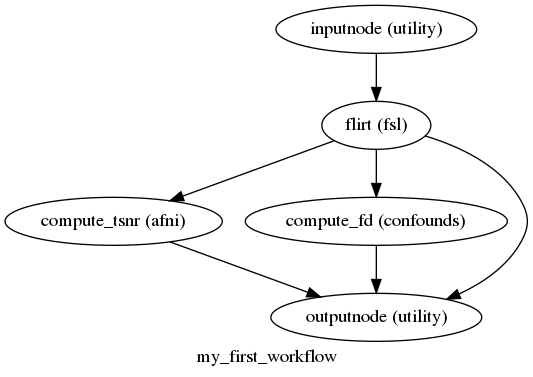

In [62]:
wf.write_graph('myfirstworkflow')

from IPython.display import Image
Image('myfirstworkflow.png')

It looks OK! Let's now get some data and see if it works.

## Download some data from OpenNeuro

We are going to download some data from OpenNeuro using [DataLad](https://www.datalad.org/). This is not necessary for Nipype, but I hope these three lines of code will pique your curiosity about the wonderful possibilities of DataLad ;-)

In [67]:
# Need the following to fix asyncio issues with jupyter
# see https://github.com/datalad/datalad/issues/5409
import nest_asyncio
nest_asyncio.apply()

# import datalad to download the data
import datalad.api as dl

# Download one of my datasets from OpenNeuro ("The Grand Budapest Hotel")
# https://openneuro.org/datasets/ds003017
# We will be using datalad for this
dl.install('budapest-data', '///openneuro/ds003017')

Dataset('/home/jlg/mvdoc/gbox/experiments/mvdoc-explorations/2021-04-20-nipype-tutorial/budapest-data')

Let's check what we have downloaded

In [104]:
!ls budapest-data/

CHANGES			  sub-sid000009  sub-sid000030	sub-sid000142
code			  sub-sid000010  sub-sid000034	sub-sid000278
dataset_description.json  sub-sid000013  sub-sid000050	sub-sid000416
participants.json	  sub-sid000020  sub-sid000052	sub-sid000499
participants.tsv	  sub-sid000021  sub-sid000055	sub-sid000522
README			  sub-sid000024  sub-sid000114	sub-sid000535
sub-sid000005		  sub-sid000025  sub-sid000120	sub-sid000560
sub-sid000007		  sub-sid000029  sub-sid000134	task-movie_bold.json


In [108]:
!tree budapest-data/sub-sid000021 | head -20

budapest-data/sub-sid000021
├── anat
│   ├── sub-sid000021_acq-MPRAGE_T1w.json
│   └── sub-sid000021_acq-MPRAGE_T1w.nii.gz -> ../../.git/annex/objects/7X/qJ/MD5E-s11279957--68385e6a59f40734e6840a3dff2c0f9b.nii.gz/MD5E-s11279957--68385e6a59f40734e6840a3dff2c0f9b.nii.gz
├── fmap
│   ├── sub-sid000021_acq-25mm_magnitude1.json
│   ├── sub-sid000021_acq-25mm_magnitude1.nii.gz -> ../../.git/annex/objects/KG/Fq/MD5E-s429868--fdbd00d8833688069653f7fdf1df4ad5.nii.gz/MD5E-s429868--fdbd00d8833688069653f7fdf1df4ad5.nii.gz
│   ├── sub-sid000021_acq-25mm_magnitude2.json
│   ├── sub-sid000021_acq-25mm_magnitude2.nii.gz -> ../../.git/annex/objects/4q/4Q/MD5E-s423945--c6b82490ae03285482b46623e1770d1e.nii.gz/MD5E-s423945--c6b82490ae03285482b46623e1770d1e.nii.gz
│   ├── sub-sid000021_acq-25mm_phasediff.json
│   └── sub-sid000021_acq-25mm_phasediff.nii.gz -> ../../.git/annex/objects/wQ/vJ/MD5E-s714314--9fac3f525babe098f3b5c42efc3bef25.nii.gz/MD5E-s714314--9fac3f525babe098f3b5c42efc3bef25.nii.gz
└── func
 

For now we have only downloaded a list of files, without the actual file content (the content is saved to git with [git-annex](https://git-annex.branchable.com)). To get the data, we need to tell datalad to download the file we want.

In [69]:
# Just get one subject's run.
data_fn = 'budapest-data/sub-sid000021/func/sub-sid000021_task-movie_run-01_bold.nii.gz'
dl.get(data_fn)

[{'action': 'get',
  'path': '/home/jlg/mvdoc/gbox/experiments/mvdoc-explorations/2021-04-20-nipype-tutorial/budapest-data/sub-sid000021/func/sub-sid000021_task-movie_run-01_bold.nii.gz',
  'type': 'file',
  'refds': '/home/jlg/mvdoc/gbox/experiments/mvdoc-explorations',
  'status': 'notneeded',
  'message': 'already present'}]

Let's check if we have a brain in there.

Shape of data is (96, 96, 48, 598)


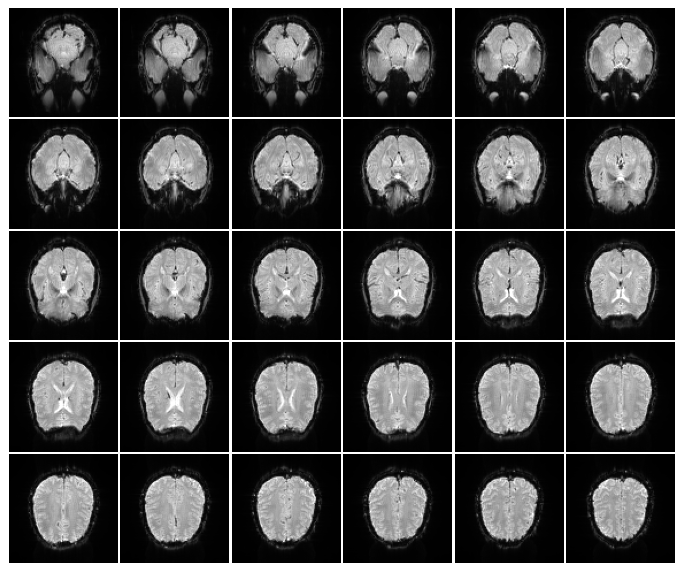

In [109]:
import nibabel as nib
import cortex

data = nib.load(data_fn).get_fdata()
print(f"Shape of data is {data.shape}")
# compute mean across TRs
data_avg = data.mean(-1)
# plot mosaic
plt.figure(figsize=(12, 12))
_ = cortex.mosaic(data_avg[..., 10:40].T, cmap='gray', vmin=0, vmax=500)

GOOD, it looks like a brain! We are going to select the first 50 TRs to make our example run faster.

In [85]:
from nilearn.image import index_img
import os

# do not use relative paths
data_fn = os.path.abspath(data_fn)
# get the first 50 TRs
data_subset = index_img(data_fn, slice(0, 50))

print(f"Shape of data_subset is {data_subset.shape}")
# save to test_data
test_data_fn = os.path.abspath('test_data.nii.gz')
data_subset.to_filename(test_data_fn)

print(f"Test data is in {test_data_fn}")

Shape of data_subset is (96, 96, 48, 50)
Test data is in /home/jlg/mvdoc/gbox/experiments/mvdoc-explorations/2021-04-20-nipype-tutorial/test_data.nii.gz


## Let's run our workflow

By default our workflow will run in the current directory. This is not great. We can set a work directory where all the intermediate files will be stored. This directory will be used for caching.

In [28]:
# set up a "work directory"
wf.base_dir = os.path.abspath('./workdir')

Now we are ready to pass our inputfile to the workflow. We do so by setting the `in_file` field of the `inputnode`.

In [88]:
# Note that we are selecting the inputs first (wf.inputs),
# then we are specifying which node we want to modify (wf.inputs.inputnode),
# and finally we set the parameter in_file 
wf.inputs.inputnode.in_file = test_data_fn

And now we are ready to run our workflow!

In [89]:
# run it -- by default it's going to run sequentially with one thread
wf.run()

210422-16:30:38,664 nipype.workflow INFO:
	 Workflow my_first_workflow settings: ['check', 'execution', 'logging', 'monitoring']
210422-16:30:38,671 nipype.workflow INFO:
	 Running serially.
210422-16:30:38,672 nipype.workflow INFO:
	 [Node] Setting-up "my_first_workflow.flirt" in "/data/tmp/tmpggvn4gww/my_first_workflow/flirt".
210422-16:30:38,676 nipype.workflow INFO:
	 [Node] Running "flirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /home/jlg/mvdoc/gbox/experiments/mvdoc-explorations/2021-04-20-nipype-tutorial/test_data.nii.gz -out /data/tmp/tmpggvn4gww/my_first_workflow/flirt/test_data_mcf.nii.gz -plots
210422-16:30:51,805 nipype.workflow INFO:
	 [Node] Finished "my_first_workflow.flirt".
210422-16:30:51,806 nipype.workflow INFO:
	 [Node] Setting-up "my_first_workflow.compute_tsnr" in "/data/tmp/tmp1vsv131y/my_first_workflow/compute_tsnr".
210422-16:30:51,813 nipype.workflow INFO:
	 [Node] Running "compute_tsnr" ("nipype.interfa

Now all our results are under the working directory

In [91]:
!tree workdir/my_first_workflow/

workdir/my_first_workflow/
├── compute_fd
│   ├── _0xb0c53395bed856aec74cf8fe48d4977f.json
│   ├── fd_power_2012.txt
│   ├── _inputs.pklz
│   ├── _node.pklz
│   ├── _report
│   │   └── report.rst
│   └── result_compute_fd.pklz
├── compute_tsnr
│   ├── _0x866e1baddb23a7f90be8cd1cbbb24749.json
│   ├── command.txt
│   ├── _inputs.pklz
│   ├── _node.pklz
│   ├── _report
│   │   └── report.rst
│   ├── result_compute_tsnr.pklz
│   └── test_data_mcf_tstat.nii.gz
├── d3.js
├── flirt
│   ├── _0x75083814f1172a2a4eb936a38cab9537.json
│   ├── command.txt
│   ├── _inputs.pklz
│   ├── _node.pklz
│   ├── _report
│   │   └── report.rst
│   ├── result_flirt.pklz
│   ├── test_data_mcf.nii.gz
│   └── test_data_mcf.nii.gz.par
├── graph1.json
├── graph.json
└── index.html

6 directories, 25 files


Each node (except the `inputnode` and the `outputnode`) has an associated folder containing the node outputs. For now we are going to ignore the other files. However, note that nodes wrapping command line arguments (such as `flirt`) contain a file named `command.txt`. This file contains the command that was run to obtain the output file. For debugging, it's often useful to check this command and run it in a terminal.

In [92]:
!cat workdir/my_first_workflow/flirt/command.txt

mcflirt -in /home/jlg/mvdoc/gbox/experiments/mvdoc-explorations/2021-04-20-nipype-tutorial/test_data.nii.gz -out /home/jlg/mvdoc/gbox/experiments/mvdoc-explorations/2021-04-20-nipype-tutorial/workdir/my_first_workflow/flirt/test_data_mcf.nii.gz -plots



Let's check the output tSNR volume and the framewise displacement

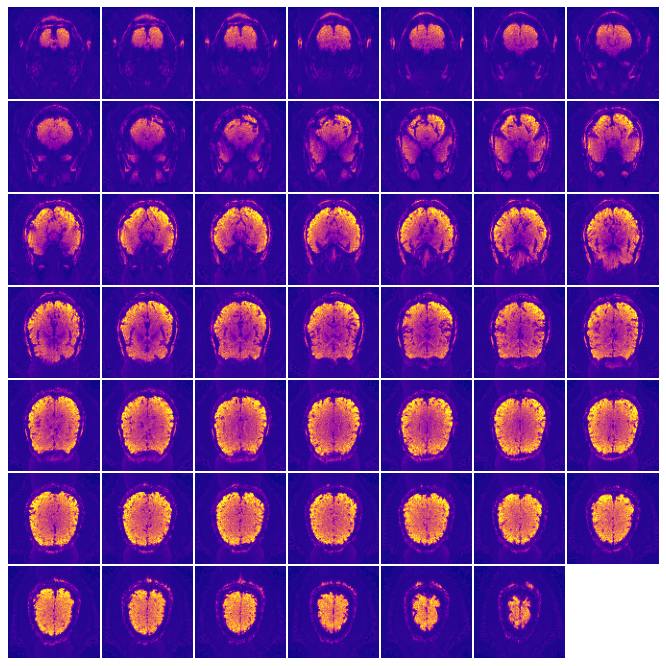

In [93]:
tsnr_img = nib.load('workdir/my_first_workflow/compute_tsnr/test_data_mcf_tstat.nii.gz')
tsnr_data = tsnr_img.get_fdata()

plt.figure(figsize=(12, 12))
_ = cortex.mosaic(tsnr_data.T, cmap='plasma', vmin=0, vmax=130)

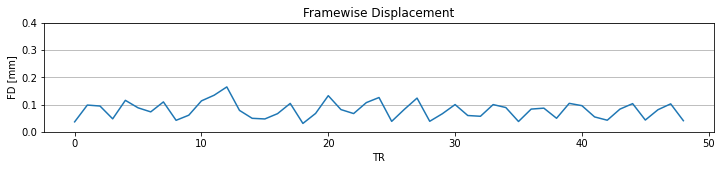

In [94]:
import numpy as np
fd_data = np.loadtxt('workdir/my_first_workflow/compute_fd/fd_power_2012.txt', skiprows=1)

fig, ax = plt.subplots(1, 1, figsize=(12, 2))
ax.plot(fd_data)
ax.set_ylim([0, .4])
ax.set_ylabel('FD [mm]')
ax.set_xlabel('TR')
ax.grid(axis='y')
_ = ax.set_title('Framewise Displacement')

### Using a DataSink

In general we don't want to look into the work directory unless we need to debug/develop our pipeline. We would like to save only the outputs we need in another folder (also called a `derivatives` folder). The `DataSink` is used for precisely this reason.

XXX: 
- show data sink. 
- show how to use function to make a node that selects the first 50 trs for all volumes
- show how to expand using a datagrabber
- put everything together